<a href="https://colab.research.google.com/github/ktshih/ktshih_64061/blob/main/Assignment%203/Shih_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting Google Drive
# Using the Google Drive icon at the top of file file navigation panel
# or uncomment the code below and run

# drive.mount('/content/drive')

# Loading the IMDB movie reviews data
!tar -xf /content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/aclImdb_v1.tar.gz -C /content
!rm -r aclImdb/train/unsup

# Loading the pretrained embeddings data GLoVe
!unzip -q /content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/glove.6B.zip -d /content


In [ ]:
# Delete previously created folders
!rm -rf aclImdb/train1
!rm -rf aclImdb/val

# Parameters
Ntrain = 10000
# Ntrain = 100
Nval = 2500
# Nval = 10000
Nword = 600
# Nword = 150
Ntoken = 20000
# Ntoken = 10000

# Preparing the IMDB reviews data

import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
train1_dir = base_dir / "train1"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    os.makedirs(train1_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    # num_val_samples = int(0.2 * len(files))
    num_val_samples = Nval
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.copy(train_dir / category / fname,
                    val_dir / category / fname)

    train_files = files[:Ntrain]
    for fname in train_files:
        shutil.copy(train_dir / category / fname,
                    train1_dir / category / fname)    

train_ds = keras.utils.text_dataset_from_directory(
    # "aclImdb/train", batch_size=batch_size
    "aclImdb/train1", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)


# Preparing integer sequence datasets

from tensorflow.keras import layers
max_length = Nword
max_tokens = Ntoken
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, None, 20000)       0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               5128448   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

'/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab/20221114-171958'

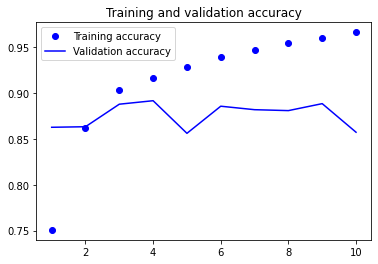

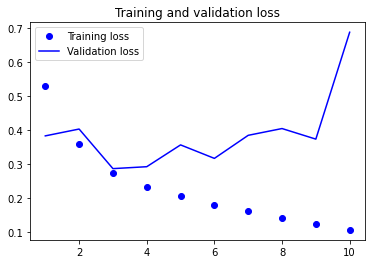

In [7]:
# Baseline

# A sequence model built on one-hot encoded vector sequences

import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

# Training a first basic sequence model

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
# print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
test_acc = model.evaluate(int_test_ds)[1]
print(f"Test acc: {test_acc:.3f}")


# Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
fig1 = plt.gcf()
pngName = "Baseline_accuracy.png"
fig1.savefig(pngName)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
fig2 = plt.gcf()
pngName = "Baseline_loss.png"
fig2.savefig(pngName)


import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import contextlib
file_path = 'stdout.txt'
with open(file_path, "a") as o:
    with contextlib.redirect_stdout(o):
        print(f"stdout file written time: {timestr}")
        print(f"Ntrain={Ntrain}")
        print(f"Nval={Nval}")
        print(f"Nword={Nword}")
        print(f"Ntoken={Ntoken}")
        print(f"Baseline Test accuracy: {test_acc:.3f}")

# Copying outpot files to Google Drive
GDrivePath = "/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

import os, shutil, glob
os.mkdir(timestr)
shutil.move("stdout.txt", timestr)
pngFiles = glob.glob("*.png")
for f in pngFiles: shutil.move(f, timestr)
shutil.move(timestr, GDrivePath)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

'/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab/20221114-184422'

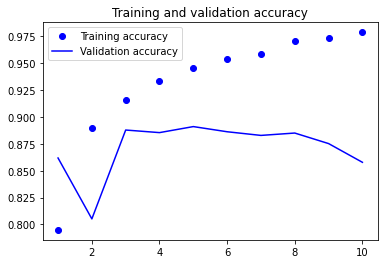

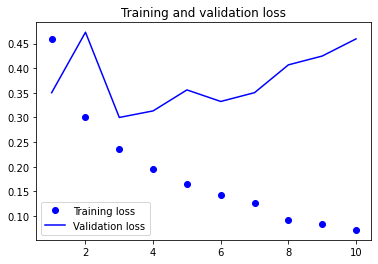

In [9]:
# Method 1
# Instantiating an Embedding layer

embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

# Model that uses an Embedding layer trained from scratch

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
# print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
test_acc = model.evaluate(int_test_ds)[1]
print(f"Test acc: {test_acc:.3f}")


# Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
fig1 = plt.gcf()
pngName = "Method1_accuracy.png"
fig1.savefig(pngName)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
fig2 = plt.gcf()
pngName = "Method1_loss.png"
fig2.savefig(pngName)


import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import contextlib
file_path = 'stdout.txt'
with open(file_path, "a") as o:
    with contextlib.redirect_stdout(o):
        print(f"stdout file written time: {timestr}")
        print(f"Ntrain={Ntrain}")
        print(f"Nval={Nval}")
        print(f"Nword={Nword}")
        print(f"Ntoken={Ntoken}")
        print(f"Method 1 Test accuracy: {test_acc:.3f}")

# Copying outpot files to Google Drive
GDrivePath = "/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

import os, shutil, glob
os.mkdir(timestr)
shutil.move("stdout.txt", timestr)
pngFiles = glob.glob("*.png")
for f in pngFiles: shutil.move(f, timestr)
shutil.move(timestr, GDrivePath)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

'/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab/20221114-190552'

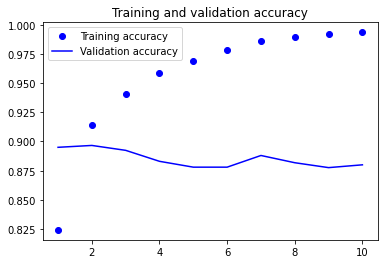

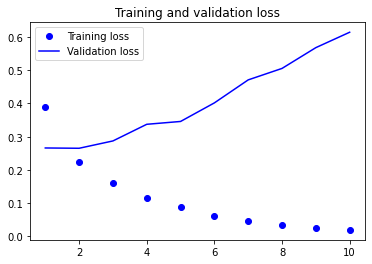

In [10]:
# Method 2
# Using an Embedding layer with masking enabled

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
# print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
test_acc = model.evaluate(int_test_ds)[1]
print(f"Test acc: {test_acc:.3f}")


# Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
fig1 = plt.gcf()
pngName = "Method2_accuracy.png"
fig1.savefig(pngName)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
fig2 = plt.gcf()
pngName = "Method2_loss.png"
fig2.savefig(pngName)

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import contextlib
file_path = 'stdout.txt'
with open(file_path, "a") as o:
    with contextlib.redirect_stdout(o):
        print(f"stdout file written time: {timestr}")
        print(f"Ntrain={Ntrain}")
        print(f"Nval={Nval}")
        print(f"Nword={Nword}")
        print(f"Ntoken={Ntoken}")
        print(f"Method 2 Test accuracy: {test_acc:.3f}")

# Copying outpot files to Google Drive
GDrivePath = "/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

import os, shutil, glob
os.mkdir(timestr)
shutil.move("stdout.txt", timestr)
pngFiles = glob.glob("*.png")
for f in pngFiles: shutil.move(f, timestr)
shutil.move(timestr, GDrivePath)


Found 400000 word vectors.
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
_________________

'/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab/20221114-193849'

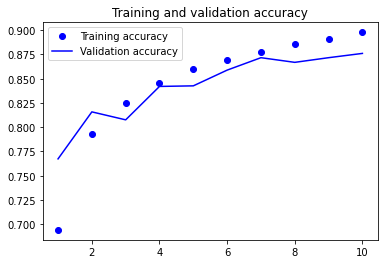

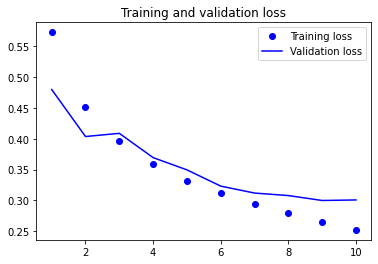

In [11]:
# Method 3
# Using pretrained word embeddings

# Parsing the GloVe word-embeddings file
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

# Preparing the GloVe word-embeddings matrix
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

# Model that uses a pretrained Embedding layer

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
# print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
test_acc = model.evaluate(int_test_ds)[1]
print(f"Test acc: {test_acc:.3f}")


# Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
fig1 = plt.gcf()
pngName = "Method3_accuracy.png"
fig1.savefig(pngName)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
fig2 = plt.gcf()
pngName = "Method3_loss.png"
fig2.savefig(pngName)


import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import contextlib
file_path = 'stdout.txt'
with open(file_path, "a") as o:
    with contextlib.redirect_stdout(o):
        print(f"stdout file written time: {timestr}")
        print(f"Ntrain={Ntrain}")
        print(f"Nval={Nval}")
        print(f"Nword={Nword}")
        print(f"Ntoken={Ntoken}")
        print(f"Method 3 Test accuracy: {test_acc:.3f}")

# Copying outpot files to Google Drive
GDrivePath = "/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

import os, shutil, glob
os.mkdir(timestr)
shutil.move("stdout.txt", timestr)
pngFiles = glob.glob("*.png")
for f in pngFiles: shutil.move(f, timestr)
shutil.move(timestr, GDrivePath)